In [1]:
import pandas as pd
import numpy as np

#Visualize a simple well
axavx = pd.read_csv("../data/train/axavx.csv", sep="\t")
axavx_intervals = pd.read_csv("../data/train/axavx_intervals.csv")

axavx.shape, axavx_intervals.shape

((1576801, 3), (23, 2))

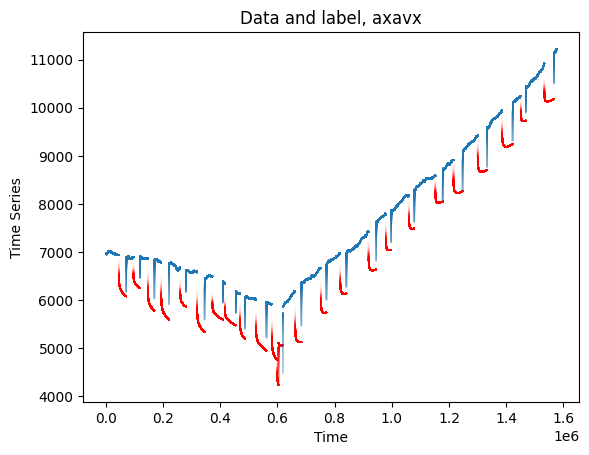

In [2]:
from utils import *

# Visualization of data and ground truth label
plot_well(
    list(
        zip(
            axavx_intervals.start, axavx_intervals.stop
        )
    ),
    axavx,
    title="Data and label, axavx",
    s=0.001,
)

In [1]:
import os


def list_and_pair_files(directory):
    time_series_files = []
    interval_files = []
    for filename in os.listdir(directory):
        if "_intervals" in filename:
            interval_files.append(os.path.join(directory, filename))
        else:
            time_series_files.append(os.path.join(directory, filename))
    return time_series_files, interval_files


def get_paired_files(time_series_files, interval_files):
    paired_files = []
    for ts_file in time_series_files:
        base_name = os.path.basename(ts_file).replace(".csv", "")
        interval_file = os.path.join(
            os.path.dirname(ts_file), f"{base_name}_intervals.csv"
        )
        if interval_file in interval_files:
            paired_files.append((ts_file, interval_file))
    return paired_files

directory = "../data/train/"
time_series_files, interval_files = list_and_pair_files(directory)
paired_files = get_paired_files(time_series_files, interval_files)

paired_files[:5]

[('../data/train/axavx.csv', '../data/train/axavx_intervals.csv'),
 ('../data/train/cswlh.csv', '../data/train/cswlh_intervals.csv'),
 ('../data/train/dsoir.csv', '../data/train/dsoir_intervals.csv'),
 ('../data/train/eppxh.csv', '../data/train/eppxh_intervals.csv'),
 ('../data/train/evctf.csv', '../data/train/evctf_intervals.csv')]

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

def load_data(timeseries_path, intervals_path):
    timeseries_df = pd.read_csv(timeseries_path, sep="\t")
    intervals_df = pd.read_csv(intervals_path)
    return timeseries_df, intervals_df


def sliding_window(data, window_size, step_size):
    segments = []
    for start in range(0, len(data) - window_size + 1, step_size):
        end = start + window_size
        segment = data[start:end]
        segments.append(segment)
    return segments


def label_segments(segments, intervals):
    labels = []
    for segment in segments:
        segment_start = segment["time"].iloc[0]
        segment_end = segment["time"].iloc[-1]
        label = 0
        for start, stop in intervals:
            if segment_start <= stop and segment_end >= start:
                label = 1
                break
        labels.append(label)
    return labels


def detrend(data, window_size):
    rolling_mean = data.rolling(window=window_size, center=True).mean()
    detrended_data = data - rolling_mean
    detrended_data = detrended_data.fillna(method="bfill").fillna(method="ffill")
    return detrended_data


def is_stationary(data, significance_level=0.05):
    result = adfuller(data.dropna(), maxlag=1)
    return result[1] < significance_level

def find_best_window(data, initial_window=10, max_window=100):
    window_size = initial_window
    while window_size <= max_window:
        detrended_data = detrend(data, window_size)
        if is_stationary(detrended_data):
            return window_size
        window_size += 10
    return initial_window


def normalize(data):
    scaler = StandardScaler()
    data["y"] = scaler.fit_transform(data[["y"]])
    return data, scaler


def load_and_prepare_data(timeseries_path, intervals_path, initial_window=10):
    timeseries_df, intervals_df = load_data(timeseries_path, intervals_path)

    # Find the best window size for detrending
    best_window_size = find_best_window(timeseries_df["y"], initial_window)

    # Detrend the data using the best window size
    timeseries_df["y"] = detrend(timeseries_df["y"], best_window_size)

    # Normalize the data
    timeseries_df, scaler = normalize(timeseries_df)

    return timeseries_df, intervals_df, scaler

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LayerNormalization,
    MultiHeadAttention,
    Add,
    Dropout,
    Flatten,
)
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split


def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    attn_output = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    attn_output = Add()([inputs, attn_output])
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(attn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Add()([attn_output, ffn_output])
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output)

    return ffn_output


def build_transformer_model(
    input_shape, head_size, num_heads, ff_dim, num_blocks, dropout=0
):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout)
        x = Dropout(dropout)(x)

    x = Flatten()(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)

    optimizer = AdamW(learning_rate=0.1, weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [6]:
from utils import DataObject
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

window_size = 100
transformer_model = build_transformer_model(
    input_shape=(window_size, 1),
    head_size=64,
    num_heads=4,
    ff_dim=64,
    num_blocks=2,
    dropout=0.2,
)

checkpoint_dir = (
    "../model/"
)
checkpoint_cb = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "model_checkpoint.h5"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

for ts_file, interval_file in paired_files:
    timeseries_df, intervals_df, scaler = load_and_prepare_data(ts_file, interval_file)
    well_data_object = DataObject(name=os.path.basename(ts_file), data=timeseries_df)
    well_data_object.assign_intervals(
        [(row["start"], row["stop"]) for _, row in intervals_df.iterrows()]
    )

    segments = sliding_window(well_data_object.data, window_size, step_size=10)
    labels = label_segments(segments, well_data_object.actual_intervals)

    X = np.array([segment["y"].values for segment in segments])
    y = np.array(labels)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    transformer_model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint_cb, early_stopping, reduce_lr],
    )

Epoch 1/50
3942/3942 [==============================] - 53s 13ms/step - loss: 0.6819 - accuracy: 0.5950 - val_loss: 0.7168 - val_accuracy: 0.6101 - lr: 0.1000
Epoch 2/50
  11/3942 [..............................] - ETA: 46s - loss: 0.7178 - accuracy: 0.5966

/home/tena/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3942/3942 [==============================] - 50s 13ms/step - loss: 0.6817 - accuracy: 0.5951 - val_loss: 0.6687 - val_accuracy: 0.6101 - lr: 0.1000
Epoch 3/50
3942/3942 [==============================] - 50s 13ms/step - loss: 0.6819 - accuracy: 0.5963 - val_loss: 0.6688 - val_accuracy: 0.6101 - lr: 0.1000
Epoch 4/50
1992/3942 [==============>...............] - ETA: 21s - loss: 0.6814 - accuracy: 0.5922